In [108]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Splitting of train and test data
- train size: 0.8, test size = 0.2, ensures positive-negative proportion in test set is the same as the training set
- using `StandardScaler` to shift the data to $\mathcal{N}(0,1)$
- select features according to mutual information

In [135]:
data_all = pd.read_csv('../data/data.csv')
target = 'Bankrupt?'
scaler = StandardScaler()
smote = BorderlineSMOTE(random_state=42)
X = data_all.drop(columns=target)
features = np.array([0,2,3,6,8,9,22,24,26,34,36,38,41,45,53,57,58,60])
X = X.iloc[:, features]
y = data_all[target]

### Data oversampling
- using `BorderlineSMOTE` to avoid deteriorate borders
- **use original data to calculate $\phi$**

In [136]:
phi = np.mean(y) # this is tricky but not considered as using test data

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train, X_test = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

In [97]:
X_resample, y_resample = smote.fit_resample(X_train, y_train)
X_resample = scaler.fit_transform(X_resample)
X_test = scaler.fit_transform(X_test)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=.2, random_state=42)

#### Decomposition using PCA

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=27, random_state=7)

In [128]:
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

### Gaussian Discriminant Analysis
- each variable satisfy gaussian, then satisfy multivariate gaussian
- $x|y=1\sim \mathcal{N}(\mu_0, \Sigma)$, $x|y=0\sim \mathcal{N}(\mu_1, \Sigma)$
- $y \sim Bernoulli(\phi)$

In [138]:
mu_0 = np.mean(X_train[y_train == 0], axis=0)
mu_1 = np.mean(X_train[y_train == 1], axis=0)
Sigma = np.cov(X_train[y_train == 0], rowvar=False) * (1-phi) + np.cov(X_train[y_train == 1], rowvar=False) * phi

### Prediction
- only need to compare $p(x|y=1)p(y=1)$ and $p(x|y=0)p(y=0)$

In [139]:
def predict(phi, mu_0, mu_1, Sigma, x_test):
    px_y1 = stats.multivariate_normal(mu_1, Sigma, allow_singular=True) # observed increased numerical stability
    px_y0 = stats.multivariate_normal(mu_0, Sigma, allow_singular=True)
    pos = px_y1.pdf(x_test) * phi
    neg = px_y0.pdf(x_test) * (1 - phi)
    return np.where(pos >= neg, 1., 0.)

In [146]:
y_pred = predict(phi, mu_0, mu_1, Sigma, X_test)

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1312
           1       0.41      0.21      0.28        52

    accuracy                           0.96      1364
   macro avg       0.69      0.60      0.63      1364
weighted avg       0.95      0.96      0.95      1364



In [157]:
# conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = np.array([
    [1318, 2],
    [39, 5]
])
recall = conf_mat[1, 1] / np.sum(conf_mat[1])
precision = conf_mat[1, 1] / np.sum(conf_mat[:, 1])
f1 = 2 * recall * precision / (recall + precision)
f1

0.19607843137254902

In [158]:
precision

0.7142857142857143

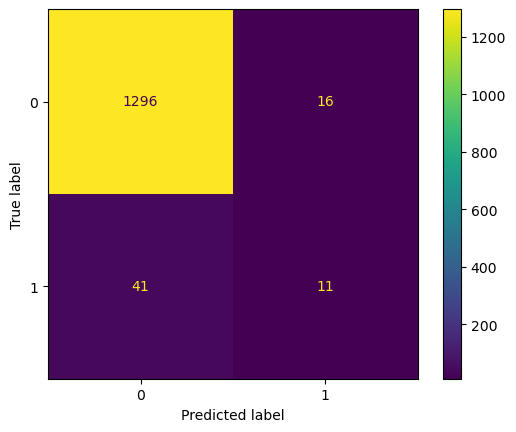

In [147]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

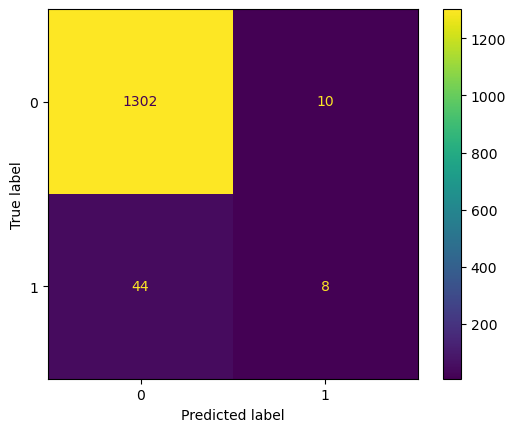

In [143]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
# import matplotlib.pyplot as plt
# plt.savefig('../thesis/images/confusion_matrix_GDA.png', dpi=200)

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1312
           1       0.44      0.15      0.23        52

    accuracy                           0.96      1364
   macro avg       0.71      0.57      0.60      1364
weighted avg       0.95      0.96      0.95      1364

